In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm
import random

### Preprocessing origin data

In [2]:
from common import get_data, get_freq_data, signal_cyclic_shift

In [3]:
X_origin, y_origin = get_data(is_one_signal=False, data_path='./data/shashlik_61_pulses.txt')

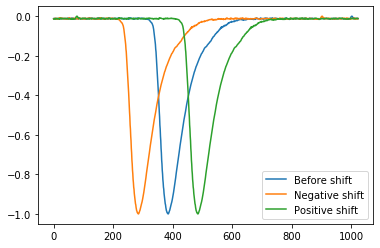

In [4]:
plt.plot(X_origin[0])
plt.plot(signal_cyclic_shift(X_origin[0], -100))
plt.plot(signal_cyclic_shift(X_origin[0], 100))

plt.legend(['Before shift', "Negative shift", "Positive shift"])
plt.show()

##### Let's shift each signal so that reference time matches for each signal

Mean reference time = 166.0


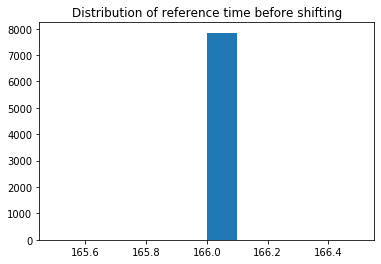

In [5]:
plt.title("Distribution of reference time before shifting")
plt.hist(y_origin)
mean_ref_time = int(y_origin.mean())
print("Mean reference time =", y_origin.mean())

### Generating multi signals

#### We will generate the signal the following way:
#### We have already shifted all the signals, so that they have the same reference time,
#### new signal will be calculated as first_signal*alpha + second_signal,
#### then normalization will be applied to new_signal, so that the impulse is in range from 0 to -1,
#### after that the first signal, the second signal and the new signal will be shifted, so that the location of minimum
#### of impulse matches for all of three signals
#### -----------------------------------------------------------------------------------------------
#### Let's figure out the location of minimum we will shift our signals to:

Mean argmin = 384.7022171253823


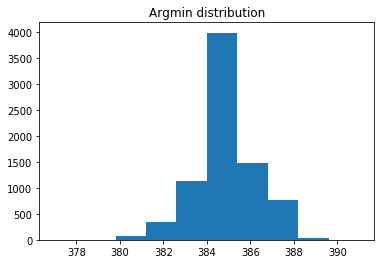

In [6]:
plt.title("Argmin distribution")
plt.hist(np.argmin(X_origin, axis=1))
mean_argmin =  int(np.argmin(X_origin, axis=1).mean())
print("Mean argmin =", np.argmin(X_origin, axis=1).mean())

In [7]:
from common import generate_multi_signal

In [8]:
# generate_multi_signal(X_origin, y_origin, 200, 0.1, to_plot=True, argmin_distr=ARGMIN_DISTR)

In [9]:
# generate_multi_signal(X_origin, y_origin, 200, 0, to_plot=True, argmin_distr=ARGMIN_DISTR)

##### Fixate tau and alpha parameters

In [10]:
tau = 0
alpha = 0.0001

### Preparing data

In [11]:
from sklearn.utils import shuffle

In [12]:
X_one_signal, y_one_signal = get_data(is_one_signal=True, data_path='./data/shashlik_61_pulses.txt')

In [13]:
ARGMIN_DISTR = np.argmin(X_one_signal, axis=1)

(array([  60.,  372.,  985., 1183., 1040., 1182., 1042., 1053.,  730.,
         201.]),
 array([354., 360., 366., 372., 378., 384., 390., 396., 402., 408., 414.]),
 <a list of 10 Patch objects>)

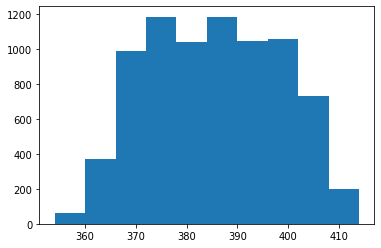

In [14]:
plt.hist(ARGMIN_DISTR)

In [19]:
def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    X = []
    y = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        
        if i < pos_size:
#             X.append(random.choice(X_one_signal))
            X.append(generate_multi_signal(X_origin, y_origin, tau, alpha, argmin_distr=ARGMIN_DISTR)['first_impulse'])

            y.append(1)
        else:
            X.append(generate_multi_signal(X_origin, y_origin, tau, alpha, argmin_distr=ARGMIN_DISTR)['multi_impulse'])
            y.append(0)
   
    X = np.array(X)
    y = np.array(y)
   
    if to_print:
#         print("X positive shape:", X_positive.shape)
#         print("y positive shape:", y_positive.shape)
#         print("X negative shape:", X_negative.shape)
#         print("y negative shape:", y_negative.shape)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

    return X, y

In [20]:
# alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
alpha_range = np.array([0])
tau_range = np.arange(-25, 25, 1)

In [21]:
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=5000, to_print=True)

X shape: (5000, 1024)
y shape: (5000,)


In [22]:
X.shape

(5000, 1024)

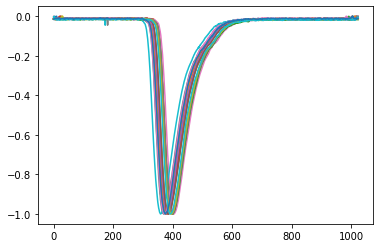

In [23]:
for i in range(50):
    if y[i] == 0:
        plt.plot(X[i])
plt.show()

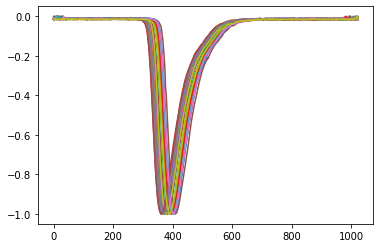

In [24]:
for i in range(50):
    if y[i] == 1:
        plt.plot(X[i])
plt.show()

### Splitting our data for train and test

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

print("X_train.shape:", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train.shape: (3500, 1024)
y_train.shape (3500,)
X_test shape: (1500, 1024)
y_test shape: (1500,)


### Ensemble

In [26]:
from scipy.stats import rankdata
from itertools import cycle
from sklearn.base import BaseEstimator, ClassifierMixin

class ShuffleVoter(BaseEstimator, ClassifierMixin):  
    """
       scikit-learn based voting aggregation ensembling.
       Using bootstrapping creates a set of models, differing only by which data sample they are fed
       """

    def __init__(self, models):
        """
        model - base model ( or a pipeline ) ( unfitted )
        """
        self.models = models
        
    def ensemble_predictions(self, predictions, weights, type_="harmonic"):
        """
        Combines probabilistic class estimates using a variety of strategies.
        Linear, harmonic, geometric and rank averaging are supported at this moment. 
        Insipred by well known Abhishek's kernel on Kaggle 
        model - base model ( or a pipeline ) ( unfitted )
        """
        assert np.isclose(np.sum(weights), 1.0)
        if type_ == "linear":
            res = np.average(predictions, weights=weights, axis=0)
        elif type_ == "harmonic":
            res = np.average([1 / p for p in predictions], weights=weights, axis=0)
            return 1 / res
        elif type_ == "geometric":
            numerator = np.average(
                [np.log(p) for p in predictions], weights=weights, axis=0
            )
            res = np.exp(numerator / sum(weights))
            return res
        elif type_ == "rank":
            res = np.average([rankdata(p) for p in predictions], weights=weights, axis=0)
            return res / (len(res) + 1)
        return res


    def fit( self, X, y, n_boots = 14, test_size = 100 ):
        """
        n_boots - number of bootstrapping iterations ( and respective models built)
        """
        self.clfs  = []
        for i, model in zip(range(n_boots), cycle(self.models)):
            X_tr, X_te, y_tr, y_te = train_test_split( X, y, test_size=test_size, random_state=3521 + i*11)

            pa_clf = model
            pa_clf.fit(X_tr, y_tr)

            self.clfs.append(pa_clf)

    def predict( self, X, ensemble_type = 'rank'):
        # TODO: nonuniform weights
        
        n_boots = len( self.clfs)
        preds = [ clf.predict(X) for clf in self.clfs ]
#         return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)
        return np.round(self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type))

    
    def predict_proba( self, X, ensemble_type = 'rank' ):
        n_boots = len( self.clfs)
        preds = [ clf.predict_proba(X) for clf in self.clfs ]
        return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)


### Defining pipelines

In [27]:
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [28]:
import pickle

MODEL_LOAD_PATH = './models/classifier/'

def load_model(path):
    with open(path, 'rb') as fid:
        model = pickle.load(fid)
        return model
    
def get_models(freq=1):
    kn_model = load_model(MODEL_LOAD_PATH + 'KNeighborsClassifier_freq_' + str(freq) + '.pkl')
    dt_model = load_model(MODEL_LOAD_PATH + 'DecisionTreeClassifier_freq_' + str(freq) + '.pkl')
#     nb_model = load_model(MODEL_LOAD_PATH + 'GaussianNB_freq_' + str(freq) + '.pkl')
#     pa_model = load_model(MODEL_LOAD_PATH + 'PassiveAggressiveClassifier_freq_' + str(freq) + '.pkl')
    rf_model = load_model(MODEL_LOAD_PATH + 'RandomForestClassifier_freq_' + str(freq) + '.pkl')
    
    pipelines = {'kn': kn_model, 'dt': dt_model, 'rf': rf_model}
    
    return pipelines

In [29]:
models = get_models()

In [30]:
models

{'kn': KNeighborsClassifier(algorithm='ball_tree', leaf_size=50, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=6, p=1,
                      weights='distance'),
 'dt': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=16,
                        max_features='sqrt', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=10,
                        min_weight_fraction_leaf=0.0011012880111856103,
                        presort=False, random_state=None, splitter='best'),
 'rf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                        max_depth=16, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=3, min_samples_split=3,
                        min_weight_fraction_leaf=0

### Pipelines scores:

In [31]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [32]:
for model_name, model in models.items():
    print("Model name:", model_name)
    
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
    scores = cross_validate(model, X, y, scoring=scoring, cv=10)
    for score in scoring.keys():
        print(score, "%0.5f (+/- %0.5f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))
    print('------------------------------')

Model name: kn
accuracy 0.51900 (+/- 0.05256)
precision 0.51960 (+/- 0.05363)
recall 0.52040 (+/- 0.04616)
f1_score 0.51976 (+/- 0.04479)
------------------------------
Model name: dt
accuracy 0.49940 (+/- 0.04504)
precision 0.49730 (+/- 0.04217)
recall 0.57880 (+/- 0.33834)
f1_score 0.52518 (+/- 0.15647)
------------------------------
Model name: rf
accuracy 0.48920 (+/- 0.04727)
precision 0.48985 (+/- 0.04765)
recall 0.49040 (+/- 0.04749)
f1_score 0.48980 (+/- 0.04026)
------------------------------


### Ensemble score

In [63]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
       'precision' : make_scorer(precision_score),
       'recall' : make_scorer(recall_score), 
       'f1_score' : make_scorer(f1_score)}

my_shuffle_voter = ShuffleVoter(list(models.values()))
scores = cross_validate(my_shuffle_voter, X, y, scoring=scoring, cv=5)
for score in scoring.keys():
    print(score, "%0.9f (+/- %0.9f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))

accuracy 0.552200000 (+/- 0.028153863)
precision 0.551818527 (+/- 0.036277982)
recall 0.573600000 (+/- 0.152407874)
f1_score 0.559300940 (+/- 0.064992452)


### Let's plot accuracy scores for different sampling frequency values

In [33]:
alpha_values = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_values = range(-25, 30, 5)
freq_values = freq_values = [1, 5, 10, 15, 25, 50, 60, 75, 85, 100]
# alpha_values = np.around(np.arange(0, 100, 2), decimals=2)

In [53]:
def calculate_scores(X, y, alpha_values, tau_values, data_size=100, freq=1):
    scores_dict = {}    
    models = get_models(freq=freq)
    model = ShuffleVoter(list(models.values()))
    X_freq = get_freq_data(X, freq=freq)
    model.fit(X_freq, y)

    
    for tau in tqdm.tqdm(tau_values):
        scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))
        for alpha in alpha_values:
            X_cur, y_cur = prepare_data(X_origin, y_origin, [tau], [alpha], data_size=data_size)
            X_cur = get_freq_data(X_cur, freq=freq)
            
            y_pred = model.predict(X_cur)
            scores_dict[tau][alpha] = accuracy_score(y_pred, y_cur)
    return scores_dict

In [54]:
def dict_to_arrays(scores_dict):
    x, y, z = [], [], []
    for tau, alpha_dict in scores_dict.items():
        for alpha, score in alpha_dict.items():
            x.append(tau)
            y.append(alpha)
            z.append(score)
            
    return [x, y, z]

In [55]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
# matplotlib.use('Qt4Agg')

def plot_score_3d(scores_dict):
    x, y, z = dict_to_arrays(scores_dict)
    alpha_values = list(scores_dict[list(scores_dict.keys())[0]].keys())
    
    fig1 = matplotlib.pyplot.figure(figsize=(7, 5))
    ax1 = Axes3D(fig1)

    ax1.set_yticks(np.log10(alpha_values[::10]))
    ax1.set_yticklabels(alpha_values[::10])

    ax1.set_xlabel(r"${\tau}$", fontsize=15)
    ax1.set_ylabel(r"${\alpha}$", fontsize=15)
    ax1.set_zlabel('Accuracy', fontsize=15)

#     ax1.view_init(30, 150)
    ax1.plot(10*x, np.log10(10*y), 10*z, 'ro', color='b', linewidth=3)

    for angle in range(0, 180):
        ax1.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

    plt.show()

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

VMIN = 0.4
VMAX = 1
STEP = 0.1
ORIGIN_FREQ = 5000

def plot_color_map(scores_dict, alpha_values, tau_values, alpha_freq=10, tau_freq=2, freq=1, cmap='spring'):
    _, _, z = dict_to_arrays(scores_dict)
    z = np.array(z)
    Z = z.reshape((len(tau_values), len(alpha_values)))

    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.title("Accuracy, frequency = " + str(int(ORIGIN_FREQ/freq)) + ' [MHZ]', fontsize=13, weight='heavy')
    plt.xlabel("Two signals ratio", fontsize=12)
    plt.ylabel("Delta t [ns]", fontsize=12)
    plt.xticks([alpha_freq*i for i in range(len(alpha_values[::alpha_freq]))], alpha_values[::alpha_freq])
    plt.yticks([tau_freq*i for i in range(len(tau_values[::tau_freq]))], [0.2*el for el in tau_values[::tau_freq]])

    im = ax.imshow(Z, interpolation='bilinear', cmap=cmap, aspect='auto', vmin=VMIN, vmax=VMAX)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.arange(VMIN, VMAX, STEP))
    cbar.set_ticklabels(np.round(np.arange(VMIN, VMAX, STEP), decimals=1))
    cbar.set_label('Accuracy', rotation=90, fontsize=13)
    plt.show()

In [57]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
for freq in freq_values:
    plot_color_map(load_obj('scores_freq=' + str(freq)), alpha_values, tau_values, freq=freq)

100%|██████████| 11/11 [1:44:18<00:00, 568.95s/it]


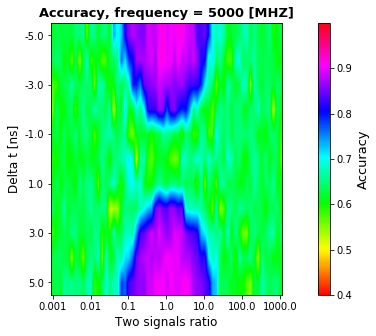

100%|██████████| 11/11 [1:04:25<00:00, 351.42s/it]


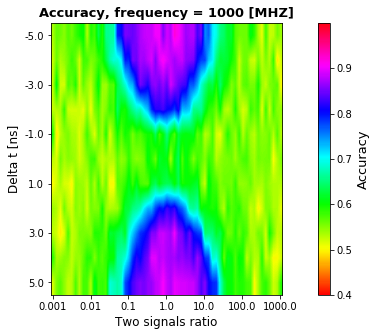

100%|██████████| 11/11 [1:02:03<00:00, 338.47s/it]


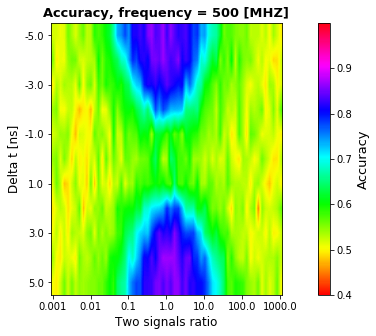

 73%|███████▎  | 8/11 [45:59<17:15, 345.32s/it]

In [ ]:
X_origin, y_origin = get_data(data_path='./data/shashlik_61_pulses.txt')
X, y = prepare_data(X_origin, y_origin, tau_values, alpha_values, to_print=False, data_size=len(X_origin))

for freq in freq_values:
    scores_dict = calculate_scores(X, y, alpha_values, tau_values, data_size=500, freq=freq)
    plot_color_map(scores_dict, alpha_values, tau_values, freq=freq, cmap='hsv')
    save_obj(scores_dict, 'scores_freq=' + str(freq))
#     plot_score_3d(scores_dict)

### Let's take a look at mistakes distribution

In [ ]:
tau = -25
data_size = 2000
freq = 1

In [ ]:
def plot_mistakes_distr(y_test, y_pred, i):
    plt.subplot(331 + i)
    plt.title("tau = %i, alpha = %0.4f, acc = %0.4f" %(tau, alpha, scores_dict[tau][alpha]), fontsize=10)
    
    fp_num = len([i for i in range(len(y_test)) if y_test[i] == 0 and y_pred[i] == 1])
    fn_num = len([i for i in range(len(y_test)) if y_test[i] == 1 and y_pred[i] == 0])
    
    x = np.arange(2)
    plt.bar(x, height=[fp_num, fn_num])
    plt.xticks(x, ['False positive','False negative'])

In [ ]:
fig=plt.figure(figsize=(12, 12))
fig.suptitle('Mistakes distribution for different params', fontsize = 15)

for i, alpha in enumerate(alpha_values[5:14], 0):
    X_origin, y_origin = get_data()
    X, y = prepare_data(X_origin, [tau], [alpha], data_size=2000)
    X = get_freq_data(X, freq=freq)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

    pipelines = get_pipelines()
    model = pipelines['kn']

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
  
    plot_mistakes_distr(y_test, y_pred, i)
plt.show()

##### As we can see our algorithm more often decides that a multi signal is a single signal